### Table of Contents

# 1. Import Data

## 1.1 Import the needed libraries

In [ ]:
from datetime import date
from datetime import datetime
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import parallel_coordinates
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


%matplotlib inline
pd.set_option('display.max_columns', None)

## 1.2 Import a integrate data

In [ ]:
df_crm = pd.read_csv('crm.csv')
df_mkt = pd.read_csv('mkt.csv')
df_sales = pd.read_excel('sales.xlsx')

In [ ]:
df = pd.merge(pd.merge(df_crm,df_sales,on='CustomerID',how="inner"),df_mkt,on="CustomerID",how="inner")

## 1.3 Set Index


In [ ]:
df.set_index('CustomerID',inplace = True)

## 1.4 Check and removing duplicates

In [ ]:
df[df.duplicated()] # checking duplicates

31 duplicated rows, with the entire same value

In [ ]:
df = df[~df.duplicated()] # drop duplicates rows

# 2. Explore Data

## 2.1 Basic Exploration

Q: _To check the number of columns and rows_ we used `shape` _attribute_

In [ ]:
df.shape

A: _The dataset has **7000 rows** and **26 columns**_

__*Q*__: Check the name of the features of the dataset we used `columns` _attribute_

In [ ]:
df.columns

Q: First glance of the dataset using `head` to show 5 rows.

In [ ]:
df.head(5)

Q: To check the basic information of the dataset we've used the `info` method

In [ ]:
df.info()

>A: We can observe the data type of the dataset and the how many of features per data type  `dtypes: float64 - (7), int64 - (15), object - (4)`, the memory usage of `1.4+MB`, and the non-null values present per columns. <br>
> Using only `info` method we understand that `'Education', 'Recency', 'MntDrinks'` have __14, 23, 28 null values__ that require some action.

# 2.2 Statistical Exploration

## 2.2.1 Numerical Variables

In [ ]:
df.describe()

> _The describe return we can get a first glance and make some conclusion:_

>__Birthyear__ - could originate an Age column for readability purposes<br>
__Income__ - Min and Max are very far from each other and far from the mean value which could indicate outliers<br>
__Recency__ - 6977 valid values, hence we should look in deep and decide on how to minimize that effect of missing values<br>
__MntMeat&Fish__ - Min and Max are distant from each other and have high standard deviation which could effect some future conclusion<br>
__MntEntries__ - Again has high standard deviation that we should analyze, Min and Max far apart, similar to MntMeat&Fish<br>
__MntVegan&Vegetarian__ - Similar to the previous two Mnt columns<br>
__MntDrinks, MntDesserts__ - Seems to be very similar between them<br>
__MntAdditionalRequests__ - The max value standard deviation seems high and also the max value very far apart from the mean<br>
__NumOfferPurchases, NumTakeAwayPurchases, NumAppVisitsMonth__  - Have a max value to distante from the mean that could be true but we need to take into account<br>
__NumAppPurchases, SumStorePurchases__ - Seems does not have strange summary statistcs<br>
__Kid_Younger6, Children_6to18__ - 75% of clients have at least one child

**Q**: Skewness of each variable 

In [ ]:
df.skew()

Concerning the variables' skewness, we can conclude the following:
- `Moderate skewness (between |0.5| and |1.0|)`: Birthyear, Income, Kid_Younger6, Children_6to18, Recency, NumAppPurchases, NumStorePurchases, NumAppVisitsMonth
- `High skewness (higher than |1.0|)`: MntMeat&Fish, MntEntries, MntVegan&Vegetarian, MntDrinks, MntDesserts, MntAdditionalRequests, NumOfferPurchases, NumTakeAwayPurchases, Complain, Response_Cmp1, Response_Cmp2, Response_Cmp3, Response_Cmp4, Response_Cmp5

In [ ]:
df.kurt()

Features with kurtosis higher than 3 could indicate presence of outliers, hence we should have special consideration with the following features:
>MntEntries, MntVegan&Vegetarian, MntDrinks, MntDesserts, NumOfferPurchases, NumAppVisitsMonth

Note: Binomial Variables Complain, and Response_Cmp1 the kurtosis we will not consider as outliers

## 2.2.2 Categorical Values

In [ ]:
df.describe(include = object)

We can conclude that the education as **14 missing** values

#### Level/Possible values of Categorical Features

### `Name` prefix unique values and count

In [ ]:
df['Name'].str.partition(" ")[0].value_counts()

With the prefix we can generate a `Male` and `Female` feature to further explore the dataset. We will deal with that in the data transformation capther

#### **`Gender`** feature creation

In [ ]:
df["Gender"] = df['Name'].str.partition(" ")[0]
df['Male'] = df['Gender'].apply(lambda x: 1 if x == "Mr." else 0)
df['Female'] = df['Gender'].apply(lambda x: 1 if x in["Miss","Mrs."] else 0)
df.drop("Gender", axis= 1, inplace=True)

### `Education` unique values and count

In [ ]:
df["Education"].value_counts()

We have some issues that will need trasformatioin:<br>
- Graduation, Master, HighSchool are written in different ways<br>
- `Basic` and `HighSchool` need different levels?

#### Education standardization

In [ ]:
df = df.replace({"Education":{"master":"Master", "graduation":"Graduation", "phd":"PhD","highschool":"HighSchool"}})

### `Marital_Status` unique values and count

In [ ]:
df["Marital_Status"].value_counts()

Similarly to previous feature we also have some issues that need transformation:<br>
- Married, Together, Single, Divorced and Widow are written with lower and capital letters
- We could also consider that Married and Together are similar and joined them in the same level<br>

#### Marital_Status standardization

In [ ]:
df = df.replace({"Marital_Status":{"married":"Married", "together":"Married", "single":"Single","widow":"Widow","divorced":"Divorced","Together":"Married"}})
df["Marital_Status"].value_counts()

`Date_Adherence` unqiue values and count

In [ ]:
df["Date_Adherence"].value_counts()

`Date_Adherence` is a date and will need transformation to a date format for further exploration

# 3. Preprocess Data

### 3.1.2. Missing Values

In [ ]:
df.isna().sum()

- **`Education`**, **`Recency`**, **`MntDrinks`** and **`MntTotal`** (due to dependancy of `MntDrinks`) have missing values

#### Filling the missing values

Fill `Education` with the mode

In [ ]:
df["Education"].fillna(df["Education"].mode()[0], inplace = True)

Fill `Recency` with the median value

In [ ]:
df["Recency"].fillna(df["Recency"].mean(), inplace = True)

Fill Mnt values

In [ ]:
df_mnt = df[[ 'MntMeat&Fish', 'MntEntries', 'MntVegan&Vegetarian', 'MntDrinks',
       'MntDesserts', 'MntAdditionalRequests']]

imputer = KNNImputer(n_neighbors=3)
array_impute = imputer.fit_transform(df_mnt)
df_mnt = pd.DataFrame(array_impute, columns = df_mnt.columns)

In [ ]:
df["MntDrinks"] = df_mnt["MntDrinks"].values

In [ ]:
df.isna().sum()

## 3.2. Data Transformation

### 3.2.1. Create new Variables

### Utils

In [ ]:
df['NumPurchasesTotal'] = df['NumTakeAwayPurchases'] + df['NumStorePurchases'] + df['NumAppPurchases']

#### Creating Age variable from the Birthyear

In [ ]:
df['Age'] = df.Birthyear.apply(lambda x: date.today().year-x)

In [ ]:
df.drop('Birthyear', axis= 1, inplace = True)

#### Creating card adherence age variable from the Date adherence

In [ ]:
df = df.replace({"Date_Adherence":{"2/29/2022": datetime.strptime("2022-03-01", '%Y-%m-%d')}})

#2022 is not a leap year, therefore 29/02/2022 is not a possible day

In [ ]:
df['daysAsCardClient'] = df['Date_Adherence'].apply(lambda x: (date.today() - x.date()).days)

In [ ]:
df.drop('Date_Adherence', axis= 1, inplace = True)

#### Fill Education

In [ ]:
edu_encode = pd.get_dummies(df.Education, drop_first= True) #TODO ver se nao ha formas melhores para tratar desta categoria
df = pd.concat([df, edu_encode], axis = 1)

In [ ]:
df.head()

In [ ]:
df.drop('Education', axis = 1, inplace = True)

#### Fill Maritial Status

In [ ]:
marital_encode = pd.get_dummies(df.Marital_Status, drop_first= True)
df = pd.concat([df, marital_encode], axis = 1)

In [ ]:
df.drop('Marital_Status', axis= 1, inplace = True)

#### Create MntTotal

In [ ]:
df["MntTotal"] = df['MntMeat&Fish'] + df['MntEntries'] + df['MntVegan&Vegetarian'] + df['MntDrinks'] + df['MntDesserts'] + df['MntAdditionalRequests']
df["MntTotal"]

#### Create Mnt Pday Card

In [ ]:
df['Mnt_pday_card']= df.MntTotal/df.daysAsCardClient

#### Create Response Campaigns

In [ ]:
df['Response_Campaigns'] = df['Response_Cmp1'] + df['Response_Cmp2'] + df['Response_Cmp3'] + df['Response_Cmp4'] + df['Response_Cmp5']

#### Create Total Kids

In [ ]:
df["Total_Kids"] = df["Kid_Younger6"] + df["Children_6to18"]

#### Create Has Kids

In [ ]:
df["has_Kids"] = df["Total_Kids"].apply(lambda x: 0 if x == 0 else 1)
df["has_Kids"]

#### Create age_bins

In [ ]:
df["age_bins"] = pd.cut(df["Age"], bins = 5)
age_bin = pd.get_dummies(df['age_bins'],prefix='age')
df = pd.concat([df,age_bin], axis=1)
df.drop(['age_bins'],axis=1, inplace=True)

#### Create MNT Ratios

In [ ]:
df['Pct_Meat&Fish'] = df['MntMeat&Fish']/df['MntTotal']
df['Pct_Desserts'] = df['MntDesserts']/df['MntTotal']
df['Pct_Entries'] = df['MntEntries']/df['MntTotal']
df['Pct_Drinks'] = df['MntDrinks']/df['MntTotal']
df['Pct_Vegan&Vegetarian'] = df['MntVegan&Vegetarian']/df['MntTotal']
df['Pct_AdditionalRequests'] = df['MntAdditionalRequests'] /df['MntTotal']

#### Create Behavior Ratios

In [ ]:
df['Pct_Store'] = df['NumStorePurchases']/df['NumPurchasesTotal']
df['Pct_App'] = df['NumAppPurchases']/df['NumPurchasesTotal']
df['Pct_TakeAway'] = df['NumTakeAwayPurchases']/df['NumPurchasesTotal']

## Incoherencies

Check and drop consumers who have monetary spent but don't have a purchase registry

In [ ]:
df[(df[['MntMeat&Fish', 'MntEntries',
        'MntVegan&Vegetarian', 'MntDrinks', 'MntDesserts',
        'MntAdditionalRequests']].sum(axis = 1) > 0) & (df[['NumAppPurchases', 'NumTakeAwayPurchases', 'NumStorePurchases']].sum(axis = 1) <= 0)]

In [ ]:
df.drop(df.loc[(df[['MntMeat&Fish', 'MntEntries',
                    'MntVegan&Vegetarian', 'MntDrinks', 'MntDesserts',
                    'MntAdditionalRequests']].sum(axis = 1) > 0) & (df[['NumAppPurchases', 'NumTakeAwayPurchases', 'NumStorePurchases']].sum(axis = 1) <= 0)].index,inplace=True)

In [ ]:
df[(df[['MntMeat&Fish', 'MntEntries',
        'MntVegan&Vegetarian', 'MntDrinks', 'MntDesserts',
        'MntAdditionalRequests']].sum(axis = 1) > 0) & (df[['NumAppPurchases', 'NumTakeAwayPurchases', 'NumStorePurchases']].sum(axis = 1) <= 0)] # confirmação do ajuste

Check consumers who have more Individual Purchases than total Purchases

In [ ]:
df[(df['NumOfferPurchases'] > df[['NumAppPurchases','NumTakeAwayPurchases','NumStorePurchases']].sum(axis=1))]

In [ ]:
df.loc[(df['NumOfferPurchases'] > df[['NumAppPurchases','NumTakeAwayPurchases','NumStorePurchases']].sum(axis=1)),'NumOfferPurchases'] = df['NumAppPurchases'] + df['NumTakeAwayPurchases'] + df['NumStorePurchases']

In [ ]:
df[(df['NumOfferPurchases'] > df[['NumAppPurchases','NumTakeAwayPurchases','NumStorePurchases']].sum(axis=1))] # confirmação do ajuste

### 3.1.2 Outliers

In [ ]:
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
#ax1.boxplot(df['MntVegan&Vegetarian'])
#ax2.boxplot(df['Income'])

In [ ]:
df.drop(df[abs(zscore(df['MntVegan&Vegetarian'])) > 3].index,
        inplace=True)
df.drop(df[abs(zscore(df['Income'])) > 3].index, inplace=True)


In [ ]:
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
#ax1.boxplot(df['MntVegan&Vegetarian'])
#ax2.boxplot(df['Income'])

# 3.1.1 Skewness Correction

In [ ]:
df['MntMeat&Fish'] = df['MntMeat&Fish'].apply(lambda x: np.log10(x+1))
df['MntVegan&Vegetarian'] = df['MntVegan&Vegetarian'].apply(lambda x: np.log10(x+1))
df['MntEntries'] = df['MntEntries'].apply(lambda x: np.log10(x+1))
df['MntDrinks'] = df['MntDrinks'].apply(lambda x: np.log10(x+1))
df['MntDesserts'] = df['MntDesserts'].apply(lambda x: np.log10(x+1))
df['MntAdditionalRequests'] = df['MntAdditionalRequests'].apply(lambda x: np.log10(x+1))
df['NumOfferPurchases'] = df['NumOfferPurchases'].apply(lambda x: np.log10(x+1))
df['NumTakeAwayPurchases'] = df['NumTakeAwayPurchases'].apply(lambda x: np.log10(x+1))
df['Complain'] = df['Complain'].apply(lambda x: np.log10(x+1))
df['Response_Cmp1'] = df['Response_Cmp1'].apply(lambda x: np.log10(x+1))
df['Response_Cmp2'] = df['Response_Cmp2'].apply(lambda x: np.log10(x+1))
df['Response_Cmp3'] = df['Response_Cmp3'].apply(lambda x: np.log10(x+1))
df['Response_Cmp4'] = df['Response_Cmp4'].apply(lambda x: np.log10(x+1))
df['Response_Cmp5'] = df['Response_Cmp5'].apply(lambda x: np.log10(x+1))

## Data Review

Ver a dataframe no seu estado final
Drop: Id, name, birthyear, date_adherence, total_kids, mntTotal

In [ ]:
df.head()

In [ ]:
df.describe()

Utilizar df como base para treinos/clustering

In [ ]:
df.drop(['Name'], axis = 1, inplace = True)

In [ ]:
df.columns

# Feature Selection

As the problem is not a classification problem we will need to adapt our data so it can be used in classifiers. We will use Random Forest Classifiers as tools for feature selection, using MntTotal as the target variable, as our goal is to devise a marketing campaign that aims to increase sales

## Redução de Dimensões e Scaling
Pipeline para passar da df para uma df que se possa utilizar nos modelos de clustering.
1: Selecionar as colunas a partir da dataframe df. Criar uma copia com as colunas desejadas utilizando a função df_select
2: Aplicar a função scaling_dfs que aplica scaling à dataframe obtida no passo anterior e retorna uma df scaled
3: Escolher o método de redução de dimensoes a aplicar: PCA ou Feature selection com RandomForest
3.1.1 PCA: Utilizar a função PCA_graph_df para ver quantos principal components serão necessários para a variancia desejada
3.1.2 PCA: Utilizar a função create_PCA_df para aplicar PCA com o numero de componentes desejado à dataframe obtida em 2, obtendo uma df com o numero de colunas igual ao numero de principal components
3.2.1 Feature Selection com RandomForest: Utilizar a função RFR_feature_select para obter os nomes das colunas consideradas importantes e o MSE (para ver se a abordagem é viável). Atenção que a df utilizada para fazer feature selection deverá ser uma com as colunas desejadas mas **SEM SCALING**, para que não haja bleeding de informação.
3.2.2 Feature Selection com RandomForest: Utilizar a função selected_features_df para obter uma df sem scaling com apenas as colunas obtidas no passo anterior mais a coluna da target variable. **Aplicar o passo 2 apenas agora**



In [ ]:
def df_select(column_names: list, df: pd.DataFrame):
    df_train = df[column_names].copy()
    return df_train

In [ ]:
def scaling_dfs(df):
    scaler = MinMaxScaler()
    df_total_scaled = pd.DataFrame(scaler.fit_transform(df))
    return df_total_scaled

In [ ]:
def pca_graph_df(df_scaled: pd.DataFrame, exp_variance: int):
    pca = PCA()
    pca.fit(df_scaled)
    var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

    plt.title("PCA Variance against num of Componmnets")
    plt.ylabel("Variance %")
    plt.xlabel("Number of componments")
    plt.axhline(exp_variance, color="red")

    plt.plot(var1)
    plt.grid()

In [ ]:
def create_pca_df(n_components: int, df_scaled: pd.DataFrame):
    pca = PCA(n_components= n_components)
    pca_train=pca.fit_transform(df_scaled)
    return pca_train

In [ ]:
def rfr_feature_select(df: pd.DataFrame, target_var: str):

    x = df.drop([target_var], axis= 1).copy()
    y = df[target_var].copy()

    x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=1)

    y_train = np.array(y_train).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1, 1)

    scalerx = MinMaxScaler()
    scalery = MinMaxScaler()

    scalerx = scalerx.fit(x_train)
    scalery = scalery.fit(y_train)

    x_train = pd.DataFrame(scalerx.transform(x_train), columns= x.columns)
    x_test = pd.DataFrame(scalerx.transform(x_test), columns= x.columns)

    y_train = pd.DataFrame(scalery.transform(y_train))
    y_test = pd.DataFrame(scalery.transform(y_test))

    rfr = RandomForestRegressor(random_state= 1)
    rfr.fit(x_train, y_train)

    importances = pd.Series(rfr.feature_importances_, index= x_train.columns)
    threshold = importances.median()
    selected_features = x_train.reset_index(drop=True).loc[:, importances >= threshold]

    new_rfr = RandomForestRegressor(random_state=1)
    new_rfr.fit(selected_features, y_train)

    x_test= x_test[selected_features.columns]
    y_pred = new_rfr.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)

    return list(selected_features.columns), mse

In [ ]:
def selected_features_df(selected_columns: list, target_variable: str, df: pd.DataFrame):
    selected_columns = selected_columns.append(target_variable)
    selected_df = df[selected_columns].copy()
    return selected_df

In [ ]:
def elbow_nclusters(model_type, dimensioned_df: pd.DataFrame, cluster_range: int):
    ks = range(1,cluster_range)
    inertias = []

    for k in ks:
        model = model_type(n_clusters = k).fit(dimensioned_df)
        inertias.append(model.inertia_)
    plt.plot(ks, inertias)

    plt.xlabel('number of clusters')
    plt.ylabel('inertia')
    plt.xticks(ks)
    plt.show()

In [ ]:
def sumsquares_nclusters(model_type,  dimensioned_df: pd.DataFrame, cluster_range: int):
    within_ss = []
    between_ss = []
    model_list = []
    n_cluster = range(1,cluster_range)

    ssc = pd.DataFrame({"model": n_cluster})

    for k in n_cluster:
        model = model_type(n_clusters=k)
        model.fit(dimensioned_df)
        within_ss.append(model.inertia_)
        between_ss.append(sum(np.min(
            cdist(dimensioned_df, model.cluster_centers_, 'euclidean'), axis=1)) / dimensioned_df.shape[0])
        model_list.append(model)

        ssc.loc[ssc["model"] == k, "within_ss"] = within_ss[-1]
        ssc.loc[ssc["model"] == k, "between_ss"] = between_ss[-1]

    ssc_melted = pd.melt(ssc, id_vars=["model"], var_name="measurement", value_name="value")

    plt.figure(figsize=(8, 6))
    sns.barplot(x="model", y=np.log10(ssc_melted["value"]),
                hue="measurement", data=ssc_melted)
    plt.title("Cluster Model Comparison")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Log10 Total Sum of Squares")
    plt.show()

## K-Means

In [ ]:
df_train = df.copy()
x= df_train.drop(['MntTotal', 'Mnt_pday_card', 'MntAdditionalRequests', 'MntDesserts', 'MntDrinks', 'MntEntries', 'MntMeat&Fish', 'MntVegan&Vegetarian'] , axis= 1)
y= df_train['MntTotal']
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=1)

y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

In [ ]:
scalerx = MinMaxScaler()
scalery = MinMaxScaler()

scalerx = scalerx.fit(x_train)
scalery = scalery.fit(y_train)

x_train = pd.DataFrame(scalerx.transform(x_train), columns= x.columns)
x_test = pd.DataFrame(scalerx.transform(x_test), columns= x.columns)

y_train = pd.DataFrame(scalery.transform(y_train))
y_test = pd.DataFrame(scalery.transform(y_test))

In [ ]:
RFR = RandomForestRegressor(n_estimators=100, max_depth=5)
RFR.fit(x_train, y_train)

In [ ]:
importances = pd.Series(RFR.feature_importances_, index= x_train.columns)
importances

In [ ]:
threshold = importances.median()
selected_features = x_train.reset_index(drop=True).loc[:, importances >= threshold]
print(selected_features.columns.to_series().reset_index(drop=True).to_string(index=False))

In [ ]:
new_RFR = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=1)
new_RFR.fit(selected_features, y_train)

In [ ]:
x_test= x_test[selected_features.columns]
y_pred = new_RFR.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)

## Data scaling
min max: income, recency, mnt..., purchases ..., age, daysasClient, mnt per ...

In [ ]:
scaler = StandardScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train))

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
df_train2 = df_train.copy()
pca.fit(df_train2)
var = pca.explained_variance_ratio_
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4) * 100)
plt.title("PCA Variance against num of Componmnets")
plt.ylabel("Variance %")
plt.xlabel("Number of componments")
l = plt.axhline(80, color="red")

In [ ]:
plt.plot(var1)
plt.grid()
pca = PCA(n_components=10)
pca_train = pca.fit_transform(df_train2)
pca_train

In [ ]:
df_train

## Model Train

In [181]:
ks = range(1,11)
inertias = []


for k in ks:
    model = KMeans(n_clusters = k).fit(pca_train)
    inertias.append(model.inertia_)

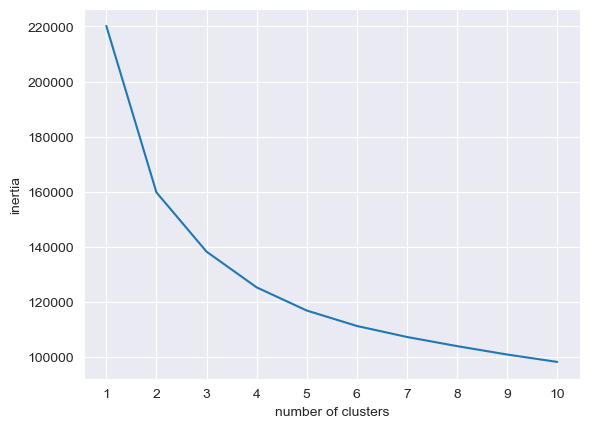

In [182]:
# Plot ks (x-axis) vs inertias (y-axis) using plt.plot().
plt.plot(ks, inertias)

# define the label for the x axis as 'number of clusters' using matplotlib.pyplot.xlabel
plt.xlabel('number of clusters')
# define the label for the y axis as 'inertia' using matplotlib.pyplot.ylabel
plt.ylabel('inertia')
# define the ticks on the x axis using the values of ks
plt.xticks(ks)
# call plt.show()
plt.show()

In [183]:
kmeans= KMeans(n_clusters = 4, max_iter =10000, random_state= 1)
kmeans.fit(pca_train)
pca_train_label = kmeans.labels_
pca_train_label = pd.DataFrame(pca_train_label)

In [185]:
df.reset_index(inplace=True)
pca_train_label.reset_index(inplace=True)
df_final=pd.concat([df,pca_train_label],axis=1)
df_final.set_index('CustomerID',inplace=True)
df_final.drop(['index'],axis=1,inplace=True)
df_final= df_final.rename(columns={0:'Cluster'})
df_final

,Income,Kid_Younger6,Children_6to18,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Response_Cmp1,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5,Male,Female,NumPurchasesTotal,Age,daysAsCardClient,Graduation,HighSchool,Master,PhD,Married,Single,Widow,MntTotal,Mnt_pday_card,Response_Campaigns,Total_Kids,has_Kids,"age_(17.943, 29.4]","age_(29.4, 40.8]","age_(40.8, 52.2]","age_(52.2, 63.6]","age_(63.6, 75.0]",Pct_Meat&Fish,Pct_Desserts,Pct_Entries,Pct_Drinks,Pct_Vegan&Vegetarian,Pct_AdditionalRequests,Pct_Store,Pct_App,Pct_TakeAway,level_0,Cluster
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14594,113947.0,0,0,43.0,3.667,3.529,3.756,3.350,2.751,2.190,0.477,10,0.903,7,4,0.0,0.000,0.301,0.000,0.000,0.0,0,1,24,42,827,1,0,0,0,0,1,0,16676.0,20.164,1,0,0,0,0,1,0,0,0.278,0.034,0.203,0.134,0.342,0.009,0.292,0.417,0.292,0,0
19070,114297.0,0,0,74.0,3.850,3.566,3.882,3.265,3.087,1.672,0.301,5,1.000,12,2,0.0,0.000,0.000,0.000,0.000,0.0,0,1,26,49,736,1,0,0,0,1,0,0,21486.0,29.193,0,0,0,0,0,1,0,0,0.330,0.057,0.171,0.086,0.355,0.002,0.462,0.192,0.346,1,0
29888,115476.0,0,0,85.0,3.616,2.581,3.689,3.561,2.581,1.462,0.301,5,0.778,7,1,0.0,0.000,0.000,0.000,0.000,0.0,1,0,17,63,459,0,0,0,1,1,0,0,13448.0,29.298,0,0,0,0,0,0,1,0,0.307,0.028,0.028,0.271,0.364,0.002,0.412,0.294,0.294,2,0
12221,101172.0,1,1,25.0,3.555,0.000,3.248,1.908,2.258,1.176,0.778,8,0.602,8,5,0.0,0.000,0.000,0.000,0.000,0.0,1,0,19,43,551,1,0,0,0,1,0,0,5634.0,10.225,0,2,1,0,0,1,0,0,0.637,0.032,0.000,0.014,0.314,0.002,0.421,0.421,0.158,3,1
21107,123128.0,0,0,64.0,3.732,3.052,3.978,2.818,2.751,1.875,0.000,4,0.903,8,5,0.0,0.301,0.000,0.301,0.000,0.0,1,0,19,52,856,0,1,0,0,0,1,0,17303.0,20.214,2,0,0,0,0,1,0,0,0.312,0.032,0.065,0.038,0.549,0.004,0.421,0.211,0.368,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30686,98968.0,0,0,66.0,3.959,2.417,3.779,2.417,0.000,1.613,0.301,6,0.845,11,2,0.0,0.000,0.000,0.000,0.000,0.0,1,0,23,29,494,0,0,0,1,0,0,0,15665.0,31.711,0,0,0,1,0,0,0,0,0.580,0.000,0.017,0.017,0.384,0.003,0.478,0.261,0.261,6859,0
17210,109977.0,0,0,8.0,3.769,3.009,4.129,3.580,0.000,1.940,0.301,5,0.903,7,2,0.0,0.000,0.000,0.000,0.000,0.0,1,0,19,38,946,1,0,0,0,0,0,0,24246.0,25.630,0,0,0,0,1,0,0,0,0.242,0.000,0.042,0.157,0.556,0.004,0.368,0.263,0.368,6860,0
29186,56039.0,0,1,30.0,2.733,0.000,2.134,0.000,0.000,0.778,0.477,3,0.301,4,6,0.0,0.000,0.000,0.000,0.000,0.0,1,0,8,56,487,0,0,0,1,1,0,0,680.0,1.396,0,1,1,0,0,0,1,0,0.794,0.000,0.000,0.000,0.199,0.007,0.500,0.375,0.125,6861,3


In [186]:
df_final.groupby('Cluster').mean().transpose()

Cluster,0,1,2,3
Income,111853.188,87802.521,4.169e+04,5.858e+04
Kid_Younger6,0.011,0.274,7.895e-01,7.619e-01
Children_6to18,0.039,0.867,1.543e-01,8.070e-01
Recency,50.114,49.325,4.827e+01,4.897e+01
MntMeat&Fish,3.719,3.581,1.979e+00,2.635e+00
MntEntries,2.884,2.288,1.932e+00,9.202e-01
MntVegan&Vegetarian,3.780,3.289,2.361e+00,2.340e+00
MntDrinks,2.872,2.319,1.912e+00,9.116e-01
MntDesserts,2.867,2.305,1.895e+00,9.390e-01
MntAdditionalRequests,1.676,1.633,1.136e+00,8.972e-01


In [187]:
df_final.groupby('Cluster').count()

,Income,Kid_Younger6,Children_6to18,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Response_Cmp1,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5,Male,Female,NumPurchasesTotal,Age,daysAsCardClient,Graduation,HighSchool,Master,PhD,Married,Single,Widow,MntTotal,Mnt_pday_card,Response_Campaigns,Total_Kids,has_Kids,"age_(17.943, 29.4]","age_(29.4, 40.8]","age_(40.8, 52.2]","age_(52.2, 63.6]","age_(63.6, 75.0]",Pct_Meat&Fish,Pct_Desserts,Pct_Entries,Pct_Drinks,Pct_Vegan&Vegetarian,Pct_AdditionalRequests,Pct_Store,Pct_App,Pct_TakeAway,level_0
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651,1651
1,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070
2,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568,1568
3,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575


## Measuring distances between clusters

In [188]:
dists = euclidean_distances(kmeans.cluster_centers_)
dists

array([[0.        , 4.95364706, 7.88844449, 8.15826728],
       [4.95364706, 0.        , 5.83059117, 4.87500598],
       [7.88844449, 5.83059117, 0.        , 4.32169276],
       [8.15826728, 4.87500598, 4.32169276, 0.        ]])

<AxesSubplot: xlabel='Income', ylabel='Single'>

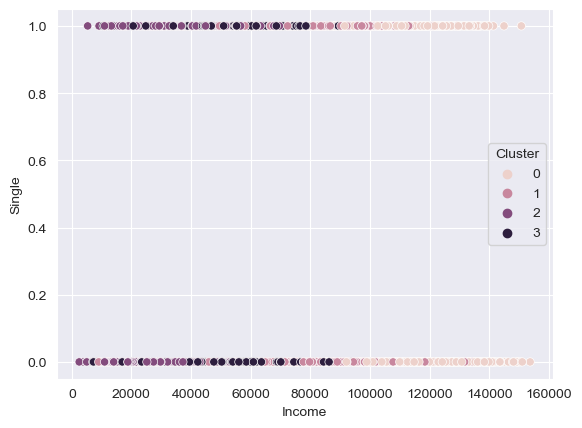

In [190]:
cluster0 = df_final[df_final.Cluster == 0]
cluster1 = df_final[df_final.Cluster == 1]
cluster2 = df_final[df_final.Cluster == 2]
cluster3 = df_final[df_final.Cluster == 3]

In [ ]:
sns.scatterplot(data=df_final, x='Income', y='Single',hue='Cluster')

<function matplotlib.pyplot.legend(*args, **kwargs)>

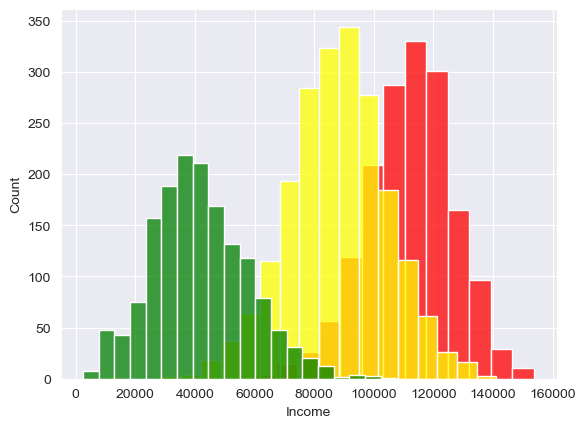

In [191]:
sns.histplot(cluster0['Income'],color='red',label='Cluster 0', bins = 20)
sns.histplot(cluster1['Income'],color='yellow',label='Cluster 1', bins = 20)
sns.histplot(cluster2['Income'],color='green',label='Cluster 2', bins = 20)
plt.legend

/var/folders/zb/r83qxb_974vbg2bs9xjz4yvh0000gp/T/ipykernel_24040/1224878855.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Cluster", y="Pct_Vegan&Vegetarian",data=df_final, ci=None)


<AxesSubplot: xlabel='Cluster', ylabel='Pct_Vegan&Vegetarian'>

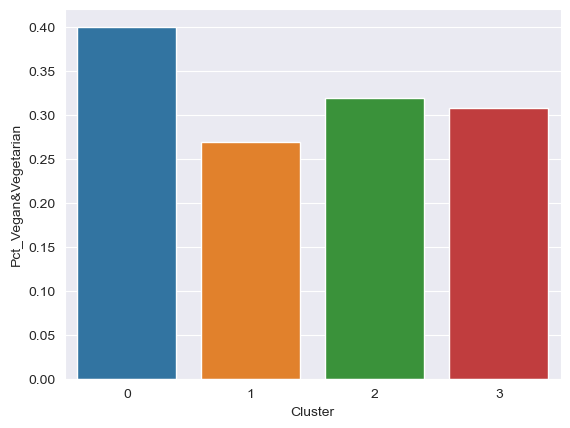

In [192]:
sns.barplot(x="Cluster", y="Pct_Vegan&Vegetarian",data=df_final, ci=None)

<AxesSubplot: xlabel='Cluster', ylabel='Pct_Meat&Fish'>

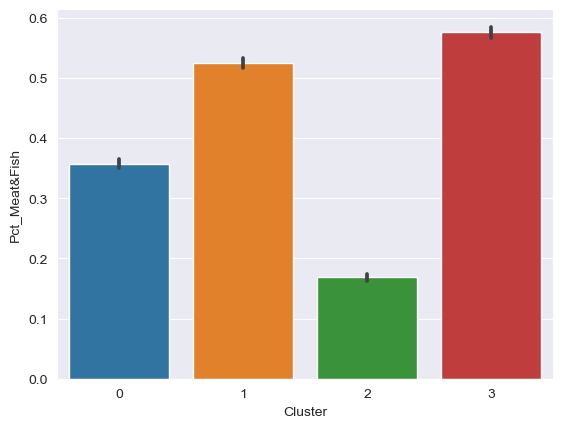

In [193]:
sns.barplot(x="Cluster", y="Pct_Meat&Fish", data=df_final)

<AxesSubplot: xlabel='Cluster', ylabel='Pct_Store'>

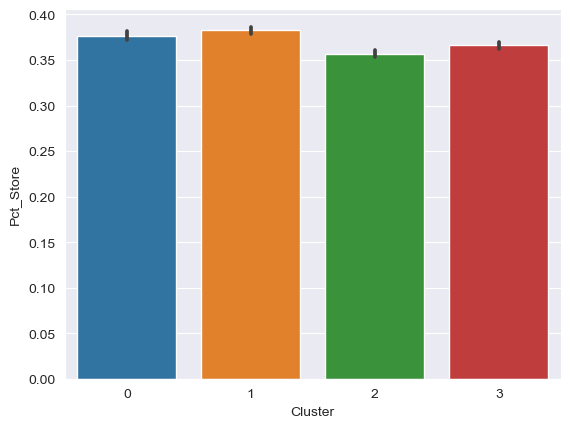

In [194]:
sns.barplot(x="Cluster", y="Pct_Store", data=df_final)

<AxesSubplot: xlabel='Pct_Meat&Fish', ylabel='Pct_Vegan&Vegetarian'>

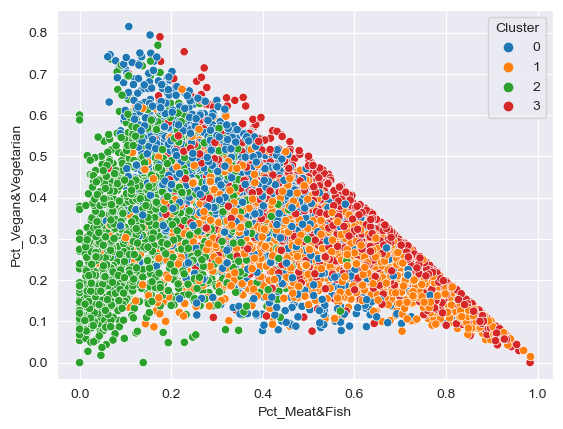

In [195]:
sns.scatterplot(data=df_final, x='Pct_Meat&Fish', y='Pct_Vegan&Vegetarian',hue='Cluster',palette='tab10')

<AxesSubplot: xlabel='Income', ylabel='Total_Kids'>

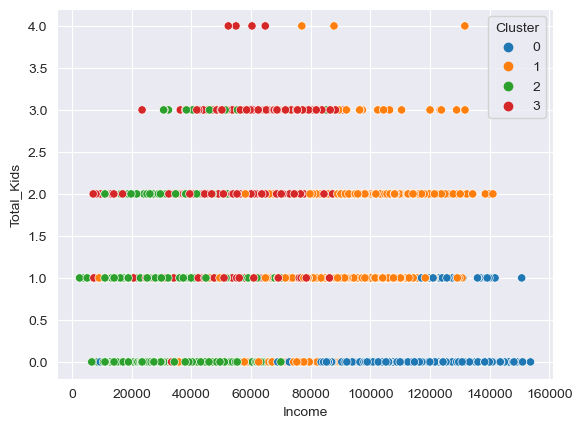

In [196]:
sns.scatterplot(data=df_final, x='Income', y='Total_Kids',hue='Cluster',palette='tab10')

<AxesSubplot: xlabel='Income', ylabel='MntTotal'>

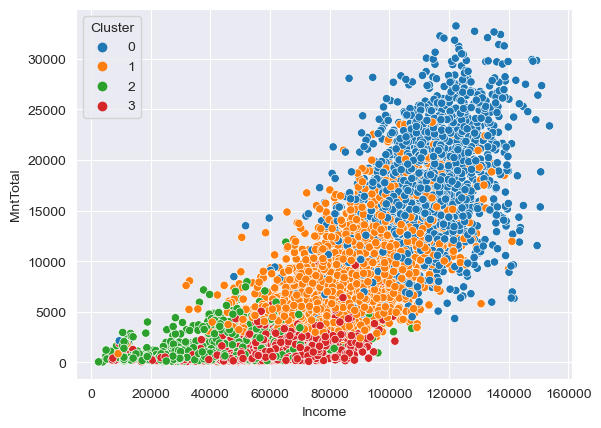

In [197]:
sns.scatterplot(data=df_final, x='Income', y='MntTotal',hue='Cluster',palette='tab10')

## K-Prototype

In [ ]:
num_cols = ['Income', 'Recency', 'MntMeat&Fish', 'MntEntries',
            'MntVegan&Vegetarian', 'MntDrinks', 'MntDesserts',
            'MntAdditionalRequests', 'NumOfferPurchases', 'NumAppPurchases',
            'NumTakeAwayPurchases', 'NumStorePurchases', 'NumAppVisitsMonth', 'Complain', 'daysAsCardClient']
cat_cols = ['Married', 'Single', 'Widow',
            'NumPurchasesTotal', 'Response_Campaigns', 'Kid_Younger6',
            'age_(17.943, 29.4]', 'age_(29.4, 40.8]', 'age_(40.8, 52.2]', 'age_(52.2, 63.6]', 'age_(63.6, 75.0]']

In [ ]:
kprototype_columns = []
kprototype_columns.extend(num_cols)
kprototype_columns.extend(cat_cols)

kprototype_df = df_select(column_names= kprototype_columns, df= df)

df_num = kprototype_df[num_cols]
df_cat = kprototype_df[cat_cols]

df_num = df_num.reset_index(drop=True)
df_cat = df_cat.reset_index(drop=True)

scaler = StandardScaler()
df_num_scaled = scaler.fit_transform(df_num)

In [ ]:
pca_graph_df(df_scaled= df_num_scaled, exp_variance= 80) #Step 3.1.1

In [ ]:
# Aplicando o PCA às colunas numéricas
pca = PCA(n_components=4)
df_num_pca = pca.fit_transform(df_num_scaled)

In [ ]:
# Concatenando as colunas numéricas do PCA com as colunas categóricas
df_combined = pd.concat([pd.DataFrame(df_num_pca), df_cat], axis=1)

In [ ]:
def plot_elbow(X, k_range):
    costs = []
    for k in k_range:
        print(k)
        kp = KPrototypes(n_clusters=k, init='Huang', n_init=20, verbose=0, n_jobs=4, random_state=1)
        kp.fit(X, categorical=[i for i in range(4, len(X.columns))])
        costs.append(kp.cost_)
    plt.plot(k_range, costs, marker='o')
    plt.xticks(k_range)
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Cost')
    plt.show()

In [ ]:
# plot_elbow(df_combined, range(1, 11))

In [ ]:
df_combined.head()

In [ ]:
# Aplicando o K-Prototypes
kp = KPrototypes(n_clusters=4, init='Huang', n_init=20, verbose=0, n_jobs=4, random_state=1)
clusters_kp = kp.fit_predict(df_combined, categorical=[i for i in range(4, len(df_combined.columns))])

# Adicionando os clusters ao DataFrame original
df['Cluster_kp'] = clusters_kp

In [ ]:
kprototype_df.head()

In [ ]:
cluster0 = df[df.Cluster_kp == 0]
cluster1 = df[df.Cluster_kp == 1]
cluster2 = df[df.Cluster_kp == 2]
cluster3 = df[df.Cluster_kp == 3]


sns.histplot(cluster0['Income'], color='red', label='Cluster 0', bins=20)
sns.histplot(cluster1['Income'], color='yellow', label='Cluster 1', bins=20)
sns.histplot(cluster2['Income'], color='green', label='Cluster 2', bins=20)
sns.histplot(cluster3['Income'], color='orange', label='Cluster 3', bins=20)

plt.legend()

In [ ]:
dists = euclidean_distances(kp.cluster_centroids_)
dists

In [ ]:
output_df= df.groupby('Cluster_kp').agg({'Income': 'mean', 'Kid_Younger6': 'mean', 'Children_6to18': 'mean', 'Complain': 'sum', 'NumPurchasesTotal': 'mean', 'Age': 'mean',
                                         'Male': 'sum', 'Female': 'sum', 'daysAsCardClient': 'mean', 'Graduation': 'sum' , 'HighSchool': 'sum', 'Master': 'sum',
                                         'PhD': 'sum', 'Married': 'sum', 'Single': 'sum','Widow': 'sum', 'MntTotal': 'mean', 'Response_Campaigns': 'mean','Total_Kids': 'mean',
                                         'Pct_Meat&Fish': 'mean', 'Pct_Desserts': 'mean', 'Pct_Entries': 'mean', 'Pct_Drinks': 'mean', 'Pct_Vegan&Vegetarian': 'mean',
                                         'Pct_AdditionalRequests': 'mean', 'Pct_Drinks': 'mean', 'Pct_Vegan&Vegetarian': 'mean', 'Pct_Store': 'mean', 'Pct_App': 'mean',
                                         'Pct_TakeAway': 'mean'
                                         })

In [ ]:
column_names = {
    'Income': 'Income (mean)',
    'Kid_Younger6': 'Kid_Younger6 (mean)',
    'Children_6to18': 'Children_6to18 (mean)',
    'Complain': 'Complain (sum)',
    'NumPurchasesTotal': 'NumPurchasesTotal (mean)',
    'Age': 'Age (mean)',
    'Male': 'Male (sum)',
    'Female': 'Female (sum)',
    'daysAsCardClient': 'daysAsCardClient (mean)',
    'Graduation': 'Graduation (sum)',
    'HighSchool': 'HighSchool (sum)',
    'Master': 'Master (sum)',
    'PhD': 'PhD (sum)',
    'Married': 'Married (sum)',
    'Single': 'Single (sum)',
    'Widow': 'Widow (sum)',
    'MntTotal': 'MntTotal (mean)',
    'Response_Campaigns': 'Response_Campaigns (mean)',
    'Total_Kids': 'Total_Kids (mean)',
    'Pct_Meat&Fish': 'Pct_Meat&Fish (mean)',
    'Pct_Desserts': 'Pct_Desserts (mean)',
    'Pct_Entries': 'Pct_Entries (mean)',
    'Pct_Drinks': 'Pct_Drinks (mean)',
    'Pct_Vegan&Vegetarian': 'Pct_Vegan&Vegetarian (mean)',
    'Pct_AdditionalRequests': 'Pct_AdditionalRequests (mean)',
    'Pct_Store': 'Pct_Store (mean)',
    'Pct_App': 'Pct_App (mean)',
    'Pct_TakeAway': 'Pct_TakeAway (mean)',
    'Cluster_kp': 'Cluster_kp'
}

# rename the columns using the dictionary
output_df = output_df.rename(columns=column_names)

In [ ]:
pd.set_option("display.precision", 3)
output_df=output_df.transpose().round(3).to_csv('output_df.csv')

In [ ]:
fig = plt.figure(figsize=(20, 10))

parallel_coordinates(df[['MntEntries', 'MntVegan&Vegetarian', 'MntDrinks', 'MntDesserts',
       'MntAdditionalRequests', 'Cluster_kp']], 'Cluster_kp', color=('red', 'blue', 'yellow', 'green'))

plt.title('Parallel Coordinates Plot')
plt.xlabel('Features')
plt.ylabel('Value')

plt.show()

In [ ]:
fig = plt.figure(figsize=(20, 10))

parallel_coordinates(df[['NumOfferPurchases', 'NumAppPurchases',
            'NumTakeAwayPurchases', 'NumStorePurchases', 'Cluster_kp']], 'Cluster_kp', color=('red', 'blue', 'yellow', 'green'))

plt.title('Parallel Coordinates Plot')
plt.xlabel('Features')
plt.ylabel('Value')

plt.show()

In [ ]:
fig = plt.figure(figsize=(20, 10))

parallel_coordinates(df[['Pct_Meat&Fish', 'Pct_Desserts', 'Pct_Entries',
       'Pct_Drinks', 'Pct_Vegan&Vegetarian', 'Pct_AdditionalRequests', 'Cluster_kp']], 'Cluster_kp', color=('red', 'blue', 'yellow'))

plt.title('Parallel Coordinates Plot')
plt.xlabel('Features')
plt.ylabel('Value')

plt.show()

In [ ]:
fig = plt.figure(figsize=(20, 10))

parallel_coordinates(df[[ 'Pct_Store', 'Pct_App', 'Pct_TakeAway', 'Cluster_kp']], 'Cluster_kp', color=('red', 'blue', 'yellow'))

plt.title('Parallel Coordinates Plot')
plt.xlabel('Features')
plt.ylabel('Value')

plt.show()